## 汽油辛烷值优化建模

以下解题过程中：
+ 参数定义
    - 《附件一：325个样本数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{s}$ 表示
    - 《附件三：285号和313号样本原始数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{r}$ 表示

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

mpl.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 配置显示中文，否则乱码
mpl.rcParams['axes.unicode_minus'] = False 

In [2]:
sample_data = "../附件一：325个样本数据.xlsx"
raw_data = "../附件三：285号和313号样本原始数据.xlsx"
adjust_data = "../附件四：354个操作变量信息.xlsx"

In [3]:
raws = pd.read_excel(io=raw_data, sheet_name="操作变量", header=[0, 1], skiprows=[0])
samples = pd.read_excel(io=sample_data, header=[0, 1], skiprows=[0])

# 查看 原始数据情况
# raws.iloc[:5, :16] 
# 查看 样本数据情况
# samples.iloc[:5, :16] 

### 问题一：

数据处理：请参考近4年的工业数据(见附件一“325个数据样本数据.xlsx”)的预处理结果，依“样本确定方法”（附件二）对285号和313号数据样本进行预处理（原始数据见附件三“285号和313号样本原始数据.xlsx”）并将处理后的数据分别加入到附件一中相应的样本号中，供下面研究使用。

即 数据预处理 ====> 补全数据&修正数据

解题思路：

+ 认真阅读《附件二：样本确定方法.docx》
+ 补全数据：
    - 即需要先确认 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 存在属性值缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$
    - 将缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$ 中的缺失的属性值从 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中以求取均值 mean($\displaystyle{\mathcal{V}_{r}}$) 的方式确定
+ 修正数据：
    - 即需要先确认 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中各属性的属性值缺失情况，对于缺失情况较大的属性则不对 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中的 属性值 $\displaystyle{\mathcal{D}}$ 进行修正
    - 将 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中需要修正的属性采用 变异系数 std($\displaystyle{\mathcal{V}_{r}}$)/mean($\displaystyle{\mathcal{V}_{r}}$) 来判断数据的离散程度，然后依据 正态分布假设检验 $norm(d \sim (mean(\displaystyle{\mathcal{V}_{r}})，std(\displaystyle{\mathcal{V}_{r}})))$，然后使用 依达拉原则 剔除一些不在范围内的样本，然后进行求取均值的操作

代码逻辑：

+ 补全数据：
    - 首先从 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中确定样本 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 缺失的属性 $\displaystyle{\mathcal{D}}_{loss}$
    - 然后对缺失的属性 $d_{loss} \in \displaystyle{\mathcal{D}}_{loss}$ 对应到 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中，逐一对每个缺失的属性值进行判别
    - 这里使用 $\frac{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} \ne 0|d_{loss}^{(i)}  \in \displaystyle{\mathcal{D}}_{loss})}{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} |d_{loss}^{(i)} \in \displaystyle{\mathcal{D}}_{loss})}$ 对当前 缺失的属性 $d_{loss}$ 在 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中数据采集的状况进行评估
        + 当比值 $ \ge \frac{3}{4} $ 时，对当前 缺失的属性的值 $\displaystyle{\mathcal{V}_{d_{loss}}}$ 进行求均值 mean($\displaystyle{\mathcal{V}_{d_{loss}}}$) 处理；
        + 当比值 $ < \frac{3}{4} $ 时，对当前 缺失的属性 $d_{loss}$ 进行直接忽略处理；

+ 修正数据：
    + 对样本 $x_{s}^{(i)}$ 进行 缺失的属性 $d_{loss}$ 求均值之前需进行异常值处理
        - 根据拉依达准则（3$\sigma$准则）去除异常值，得到 缺失的属性 $d_{loss}$ 对应的过滤后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$
        - 将处理后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$ 中的属性值进行求 均值 $\displaystyle{\mathcal{V}}_{filter_{mean}}^{d_{loss}}$ 操作加入到 $\displaystyle{\mathcal{X}}_{s}$ 中对应的 样本数据 $x_{s}^{(i)}$ 对应的 缺失的属性 $d_{loss}$ 中

In [4]:
# No.285 样本
sample_285 = samples.iloc[284]
sample_285 = sample_285.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)
# No.313 样本
sample_313 = samples.iloc[312]
sample_313 = sample_313.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)

# 查看 No.285 数据情况
# sample_285
# 查看 No.313 数据情况
# sample_313

In [5]:
def find_dummy_colmuns(sample):
    dummy_columns = []
    for (code_name, i18n_name) in sample.keys():
        if not sample[(code_name, i18n_name)]:
            # 查看 样本属性值 为 0 的列名
            # print(f"{'='*10}{i18n_name}{'='*10}")
            # print(f"{code_name}: => {sample[(code_name, i18n_name)]}")
            # print(f"{'='*35}")
            dummy_columns.append(code_name)
    return dummy_columns

In [6]:
sample_285_dummy_columns = find_dummy_colmuns(sample_285)
sample_313_dummy_columns = find_dummy_colmuns(sample_313)

# 查看 No.285 属性值为空的情况
print(f"No.285 属性值为空的列: {sample_285_dummy_columns}")
# 查看 No.313 属性值为空的情况
print(f"No.313 属性值为空的列: {sample_313_dummy_columns}")

No.285 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FC_1202.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_5102.PV', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA', 'S-ZORB.FT_5102.DACA.PV']
No.313 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA']


In [7]:
# 拆分原始数据中285号样本的数据
print("拆分出来的285号样本的原始数据")
raw_285 = raws.iloc[:40]
raw_285[sample_285_dummy_columns].head(n=5)

拆分出来的285号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FC_1202.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_5102.PV,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA,S-ZORB.FT_5102.DACA.PV
,新氢进装置流量,1#催化汽油进装置流量,D121顶去放火炬流量,新氢进装置流量,Unnamed: 110_level_1,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度,D-201含硫污水排量
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 拆分原始数据中313号样本的数据
print("拆分出来的313号样本的原始数据")
raw_313 = raws.iloc[41:]
raw_313[sample_313_dummy_columns].head(n=5)

拆分出来的313号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA
,新氢进装置流量,1#催化汽油进装置流量,新氢进装置流量,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


至此对于原始数据中的 补全数据操作 完成，可惜的是从结果看起来上面所罗列的原始数据并没有对285号和313号样本的缺失的属性值有所帮助

接下来将以原始数据集展开对样本数据集中285号和313号样本的属性值进行修正操作，值得庆幸的是，这一步可以省略上面已经验证的无法补全的一些缺失属性

In [9]:
# 统计 No.285 样本 中属性中属性值存在空值的属性
raw_285 = raw_285.drop(raw_285[sample_285_dummy_columns], axis=1)
raw_285_nonzeroratio = raw_285.astype(bool).sum(axis=0) / 40
raw_285_dummy_columns = []
for (code_name, i18n_name) in raw_285_nonzeroratio.keys():
    if raw_285_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_285_dummy_columns.append(code_name)
print(raw_285_dummy_columns)

[]


In [10]:
# 依据 拉依达准则 对 No.285 样本进行属性值数据修正
raw_285_filter = raw_285.replace(0, np.NaN)
raw_285_filter_describe = raw_285_filter.describe()
temp_ratio = raw_285_filter_describe.loc['std'] / raw_285_filter_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > 0.6:
        norm_test = stats.kstest(raw_285_filter[(code_name, i18n_name)], 'norm', (raw_285_filter_describe.loc['mean', (code_name, i18n_name)], raw_285_filter_describe.loc['std', (code_name, i18n_name)]))
        if norm_test.pvalue > 0.05:
            print(f"{'='*10} code_name: {code_name} {'='*10}")
            print(f"样本数据 参照 => {sample_313[(code_name, i18n_name)]}")
            print(f"原始数据 均值 => {raw_285_filter_describe.loc['mean', (code_name, i18n_name)]}")
            print(f"原始数据 方差 => {raw_285_filter_describe.loc['std', (code_name, i18n_name)]}")
            print(f"{'-'*40}")
            print(f"变异系数 => {temp_ratio[(code_name, i18n_name)]}")
            print(f"正态检验 => {norm_test.pvalue}")
            print(f"正态分布检验成功，依据3σ原则进行修正")
            temp_data = raw_285_filter[(code_name, i18n_name)][np.abs(raw_285_filter[(code_name, i18n_name)] - raw_285_filter_describe.loc['mean', (code_name, i18n_name)]) <= 3 * raw_285_filter_describe.loc['std', (code_name, i18n_name)]]
            print(f"修正数据 均值 => {temp_data.mean()}")
            sample_285[(code_name, i18n_name)] = temp_data.mean()
            print(f"样本数据 修正 => {sample_285[(code_name, i18n_name)]}")
        else:
            print(f"正态分布检验失败，不对样本数据进行修正")
        print(f"{'='*40}")
    else:
        sample_285[(code_name, i18n_name)] = raw_285_filter_describe.loc['mean', (code_name, i18n_name)]

In [11]:
# 统计 No.313 样本 中属性中属性值存在空值的属性
raw_313 = raw_313.drop(raw_313[sample_313_dummy_columns], axis=1)
raw_313_nonzeroratio = raw_313.astype(bool).sum(axis=0) / 40
raw_313_dummy_columns = []
for (code_name, i18n_name) in raw_313_nonzeroratio.keys():
    if raw_313_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_313_dummy_columns.append(code_name)
print(raw_313_dummy_columns)

['S-ZORB.FT_1204.PV', 'S-ZORB.FC_2432.DACA', 'S-ZORB.FT_2431.DACA', 'S-ZORB.FC_2432.PIDA.SP', 'S-ZORB.FT_1204.DACA.PV']


<AxesSubplot:>

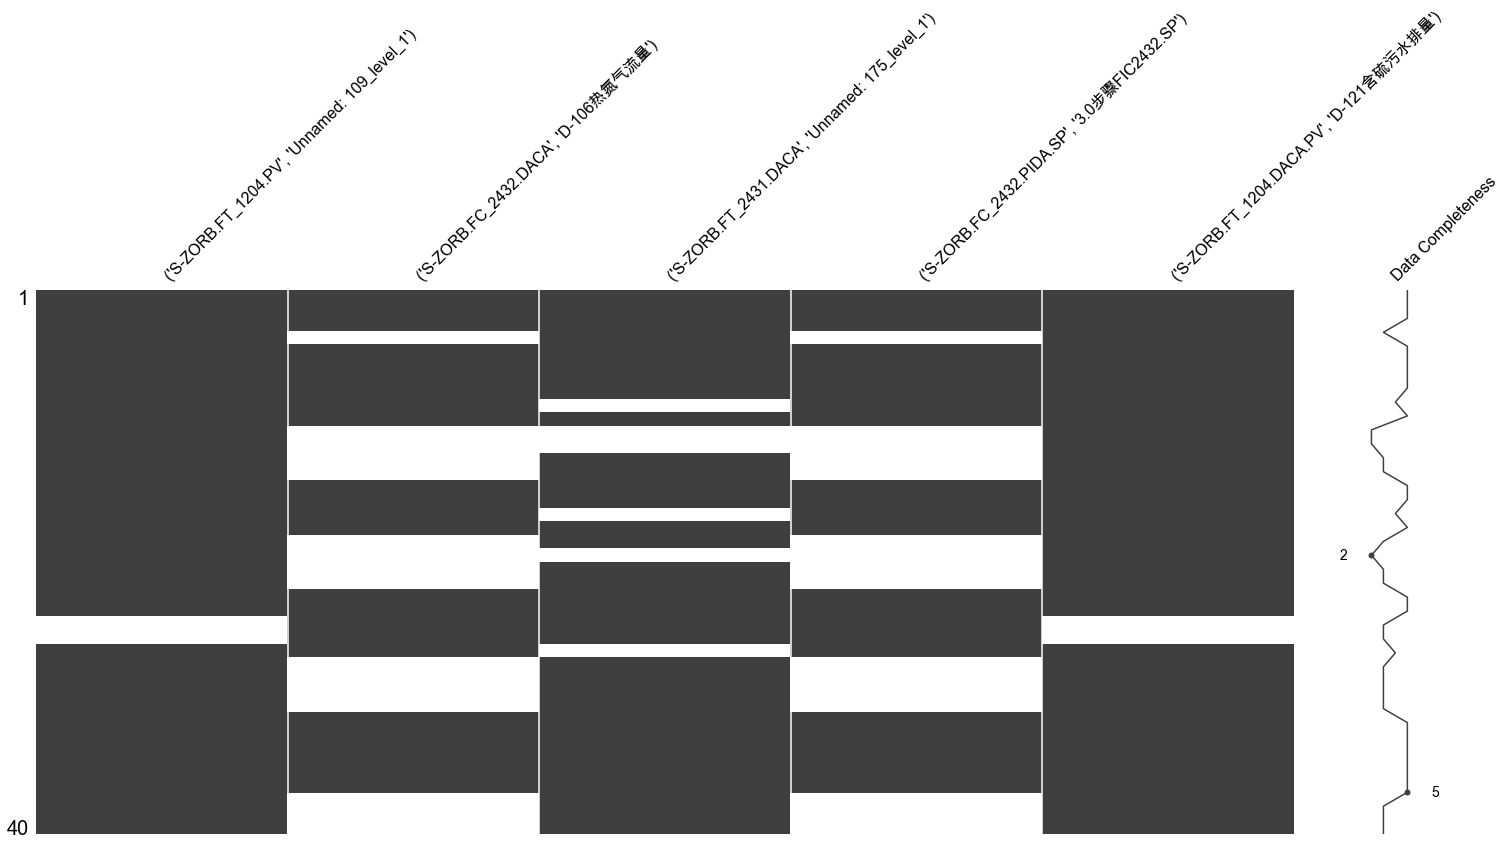

In [12]:
# 可视化呈现 No.313 样本 中属性中属性值存在空值的属性的分布
import missingno as msno
%matplotlib inline
msno.matrix(raw_313[raw_313_dummy_columns].replace(0, np.nan), labels=True)

In [13]:
# 对 No.313 样本中 存在属性值缺失的 属性进行统计学描述
dummy_raw_313 = raw_313[raw_313_dummy_columns].replace(0, np.NaN)
dummy_raw_313.describe()

,S-ZORB.FT_1204.PV,S-ZORB.FC_2432.DACA,S-ZORB.FT_2431.DACA,S-ZORB.FC_2432.PIDA.SP,S-ZORB.FT_1204.DACA.PV
,Unnamed: 109_level_1,D-106热氮气流量,Unnamed: 175_level_1,3.0步骤FIC2432.SP,D-121含硫污水排量
count,38.000000,24.000000,34.000000,24.000000,38.000000
mean,49.707433,55.025050,255.479771,55.977408,49.707433
std,8.341846,25.134146,234.464315,25.826184,8.341846
min,6.597014,0.488710,3.981225,0.177480,6.597014
25%,46.641427,38.959682,90.305070,39.000000,46.641427
50%,51.932390,68.763040,197.265750,69.000000,51.932390
75%,53.980428,74.201170,333.157850,79.000000,53.980428
max,57.424220,80.166200,937.010600,79.000000,57.424220


In [14]:
# 依据 拉依达准则 对 No.313 样本进行属性值数据修正
# 变异系数 用来衡量 数据的扩散程度
abnormal_ratio1 = 0.4  # 需要调整模型的时候参数
raw_313_filter = raw_313.drop(raw_313[['S-ZORB.FT_2431.DACA']], axis=1).replace(0, np.NaN)
raw_313_filter_describe = raw_313_filter.describe()
temp_ratio = raw_313_filter_describe.loc['std'] / raw_313_filter_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > abnormal_ratio1:
        norm_test = stats.kstest(raw_313_filter[(code_name, i18n_name)], 'norm', (raw_313_filter_describe.loc['mean', (code_name, i18n_name)], raw_313_filter_describe.loc['std', (code_name, i18n_name)]))
        if norm_test.pvalue > 0.05:
            print(f"{'='*10} code_name: {code_name} {'='*10}")
            print(f"样本数据 参照 => {sample_313[(code_name, i18n_name)]}")
            print(f"原始数据 均值 => {raw_313_filter_describe.loc['mean', (code_name, i18n_name)]}")
            print(f"原始数据 方差 => {raw_313_filter_describe.loc['std', (code_name, i18n_name)]}")
            print(f"{'-'*40}")
            print(f"变异系数 => {temp_ratio[(code_name, i18n_name)]}")
            print(f"正态检验 => {norm_test.pvalue}")
            print(f"正态分布检验成功，依据3σ原则进行修正")
            temp_data = raw_313_filter[(code_name, i18n_name)][np.abs(raw_313_filter[(code_name, i18n_name)] - raw_313_filter_describe.loc['mean', (code_name, i18n_name)]) <= 3 * raw_313_filter_describe.loc['std', (code_name, i18n_name)]]
            print(f"修正数据 均值 => {temp_data.mean()}")
            sample_313[(code_name, i18n_name)] = temp_data.mean()
            print(f"样本数据 修正 => {sample_313[(code_name, i18n_name)]}")
            print(f"{'='*40}")
    else:
        sample_313[(code_name, i18n_name)] = raw_313_filter_describe.loc['mean', (code_name, i18n_name)]

========== code_name: S-ZORB.PDC_2502.PV ==========
样本数据 参照 => 44.47553984299999
原始数据 均值 => 44.475539843
原始数据 方差 => 32.09303634057142
----------------------------------------
变异系数 => 0.7215884608452379
正态检验 => 0.23137618121257653
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 44.475539843
样本数据 修正 => 44.475539843
========== code_name: S-ZORB.PDT_3602.DACA ==========
样本数据 参照 => 0.25898975500000004
原始数据 均值 => 0.258989755
原始数据 方差 => 0.12831749812724835
----------------------------------------
变异系数 => 0.4954539538726092
正态检验 => 0.24438277364119265
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 0.258989755
样本数据 修正 => 0.258989755
========== code_name: S-ZORB.LT_9101.DACA ==========
样本数据 参照 => 1.6824734924999998
原始数据 均值 => 1.6824734925000002
原始数据 方差 => 2.109765974373722
----------------------------------------
变异系数 => 1.2539668433282742
正态检验 => 0.1964290696460399
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 1.6824734925000002
样本数据 修正 => 1.6824734925000002
========== code_name: S-ZORB.PC_2401.PIDA.OP ==========
样本数据 参照 => 49.24353829999999

### 问题二：

寻找建模主要变量：建立降低辛烷值损失模型涉及包括7个原料性质、2个待生吸附剂性质、2个再生吸附剂性质、2个产品性质等变量以及另外354个操作变量（共计367个变量），工程技术应用中经常使用先降维后建模的方法，这有利于忽略次要因素，发现并分析影响模型的主要变量与因素。因此，请你们根据提供的325个样本数据（见附件一），通过降维的方法从367个操作变量中筛选出建模主要变量，使之尽可能具有代表性、独立性（为了工程应用方便，建议降维后的主要变量在30个以下），并请详细说明建模主要变量的筛选过程及其合理性。（提示：请考虑将原料的辛烷值作为建模变量之一）。

即 特征工程 -- 特征选择&数据降维

解题思路：
+ 题意 = 建模(7个原料性质 + 2个待生吸附剂性质 + 2个再生吸附剂性质 + 2个产品性质 + 降维(354个操作变量)) => 2个产品性质
+ 特征选择
    - 数据值是否缺失过多：如果一个特征的样本数据缺失较多，则无法统计其对目标的影响，将该变量删除
        - 具体方法：分别统计操作变量的缺失值数量，然后计算其在数据中的比例，超过一定比例的特征可以删除
    - 特征是否发散：如果一个特征不发散，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用
        - 具体方法：分别计算操作变量的方差，按方差的大小（需要结合《附件四：354个操作变量信息.xlsx》中的变量阈值进行归一化处理）进行排序（从大到小排），末尾删除一定数量
    - 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择，反之则相反

> 在特征选择步骤中如果处理后存在未删除的缺失数据，需要考虑对缺失数据的补充，可以考虑对该数据的分布进行概率分布建模（例如：高斯分布）来确定其值，需要，即在进行数据降维操作之前，需要对数据完整性进行保证

+ 数据降维 (需要注意：“它们的操作变量（控制变量）之间具有高度非线性和相互强耦联的关系”题干中已经明确说明了)
    - 特征之间的相关性：因为操作变量之间是非线性关系，因此无法使用常规的线性降维方式，需要采用流形学习和核化方式对操作变量进行降维
        - 具体方法：利用t-SNE对操作变量进行降维
        

In [15]:
# 将 No.285 样本和 No.313 样本的修正数据替换到 样本数据 中
samples.iloc[284] = sample_285
samples.iloc[312] = sample_313

samples.iloc[:5, 16:23]

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.PT_2801.PV,S-ZORB.FC_2801.PV,S-ZORB.TE_2103.PV,S-ZORB.TE_2005.PV,S-ZORB.PT_2101.PV
,氢油比,反应过滤器压差,还原器压力,还原器流化氢气流量,反应器上部温度,反应器底部温度,反应器顶部压力
0,0.276318,31.211968,2.526857,647.752380,424.615900,421.608145,2.393991
1,0.277127,31.461969,2.527411,651.821920,420.953385,417.927830,2.394113
2,0.277013,31.339998,2.528865,650.747150,423.941065,420.003515,2.394545
3,0.277222,31.033443,2.530589,652.669055,423.722805,419.964775,2.392854
4,0.277310,30.826894,2.530938,649.340920,427.132000,422.128935,2.392715


In [16]:
samples.shape

(325, 370)

In [17]:
# 尝试对 样本数据 中 原料性质 进行一个正态分布检验，如果符合正态分布，则可以使用3σ检验用来剔除异常样本记录
source_samples = samples[samples.columns[[x for x in range(2, 9)]]]
source_samples_describe = source_samples.describe()
for (code_name, i18n_name) in source_samples.keys():
    norm_test = stats.kstest(source_samples[(code_name, i18n_name)], 'norm', (source_samples_describe.loc['mean', (code_name, i18n_name)], source_samples_describe.loc['std', (code_name, i18n_name)]))
    if norm_test.pvalue > 0.05:
        print(f"{'='*10} code_name: {i18n_name} {'='*10}")
        print(f"正态检验 => {norm_test.pvalue}")
        print(f"正态分布检验成功，依据3σ原则进行修正")
        samples = samples[np.abs(samples[(code_name, i18n_name)] - source_samples_describe.loc['mean', (code_name, i18n_name)]) <= 3 * source_samples_describe.loc['std', (code_name, i18n_name)]]
    else:
        pass
# 这里输出为空值 => 可得到结论: 原料性质 并不符合正态分布

In [18]:
def reshape_limit_minmax(column_name):
    samples.drop(samples[column_name].idxmax(), inplace=True)
    samples.drop(samples[column_name].idxmin(), inplace=True)

In [19]:
# 没有形成合适的正态分布，因此使用 变异系数 加 最大最小限幅降低 样本数据的 变异系数
# 变异系数 用来衡量 数据的扩散程度
abnormal_ratio2 = 0.3  # 需要调整模型的时候参数
temp_ratio = source_samples_describe.loc['std'] / source_samples_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    while temp_ratio[(code_name, i18n_name)] > abnormal_ratio2:
        reshape_limit_minmax((code_name, i18n_name))
        source_samples = samples[samples.columns[[x for x in range(2, 9)]]]
        source_samples_describe = source_samples.describe()
        temp_ratio = source_samples_describe.loc['std'] / source_samples_describe.loc['mean']
    print(f"原料属性: {i18n_name} 调整后 变异系数：{temp_ratio[(code_name, i18n_name)]}")

原料属性: 硫含量,μg/g 调整后 变异系数：0.2866704790337043
原料属性: 辛烷值RON 调整后 变异系数：0.0106046897744192
原料属性: 饱和烃,v%（烷烃+环烷烃） 调整后 变异系数：0.08684959015862909
原料属性: 烯烃,v% 调整后 变异系数：0.19385783938449927
原料属性: 芳烃,v% 调整后 变异系数：0.08430335699782192
原料属性: 溴值
,gBr/100g 调整后 变异系数：0.1514556890960077
原料属性: 密度(20℃),
kg/m³ 调整后 变异系数：0.0058737039444389265


In [20]:
samples.shape

(325, 370)

In [21]:
# 尝试对 样本数据 中 产品性质 进行一个正态分布检验，如果符合正态分布，则可以使用3σ检验用来剔除异常样本记录
produc_samples = samples[samples.columns[[x for x in range(9, 12)]]]
produc_samples_describe = produc_samples.describe()
for (code_name, i18n_name) in produc_samples.keys():
    norm_test = stats.kstest(produc_samples[(code_name, i18n_name)], 'norm', (produc_samples_describe.loc['mean', (code_name, i18n_name)], produc_samples_describe.loc['std', (code_name, i18n_name)]))
    if norm_test.pvalue > 0.05:
        print(f"{'='*10} code_name: {i18n_name} {'='*10}")
        print(f"正态检验 => {norm_test.pvalue}")
        print(f"正态分布检验成功，依据3σ原则进行修正")
        samples = samples[np.abs(samples[(code_name, i18n_name)] - produc_samples_describe.loc['mean', (code_name, i18n_name)]) <= 3 * produc_samples_describe.loc['std', (code_name, i18n_name)]]
    else:
        pass
# 这里输出为空值 => 可得到结论: 产品性质 并不符合正态分布

In [22]:
samples.shape

(325, 370)

In [23]:
# 查询 样本数据 的 零值占比
samples_nonzeroratio = samples.astype(bool).sum(axis=0) / samples.shape[0]
samples_dummy_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] != 1.0:
        print(f"None Zero Ratio: {code_name}[{i18n_name}]:  => {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_dummy_columns.append((code_name, i18n_name))

None Zero Ratio: S-ZORB.FC_2301.PV[D105流化氢气流量]:  => 0.5538461538461539
None Zero Ratio: S-ZORB.FT_9301.PV[蒸汽进装置流量]:  => 0.9876923076923076
None Zero Ratio: S-ZORB.FT_1501.PV[新氢进装置流量]:  => 0.11384615384615385
None Zero Ratio: S-ZORB.FT_5104.PV[轻烃出装置流量]:  => 0.6123076923076923
None Zero Ratio: S-ZORB.FT_9101.PV[污油出装置]:  => 0.5876923076923077
None Zero Ratio: S-ZORB.FT_9402.PV[非净化风进装置流量]:  => 0.9969230769230769
None Zero Ratio: S-ZORB.FT_1002.PV[1#催化汽油进装置流量]:  => 0.5784615384615385
None Zero Ratio: S-ZORB.FT_1003.PV[2#催化汽油进装置流量]:  => 0.9876923076923076
None Zero Ratio: S-ZORB.FT_1004.PV[3#催化汽油进装置流量]:  => 0.9415384615384615
None Zero Ratio: S-ZORB.FC_1202.PV[D121顶去放火炬流量]:  => 0.3261538461538461
None Zero Ratio: S-ZORB.FC_3103.PV[再生冷氮气流量]:  => 0.3415384615384615
None Zero Ratio: S-ZORB.FT_1002.TOTAL[0]:  => 0.4246153846153846
None Zero Ratio: S-ZORB.FT_1501.TOTAL[新氢进装置流量]:  => 0.6215384615384615
None Zero Ratio: S-ZORB.FT_5102.PV[0]:  => 0.6646153846153846
None Zero Ratio: S-ZORB.FT_3303.DA

检查下面的变量取值范围是否包含0

+ ('S-ZORB.FC_2301.PV', 'D105流化氢气流量')                    0-350
+ ('S-ZORB.FT_1501.PV', '新氢进装置流量')                      0-3500
+ ('S-ZORB.FT_5104.PV', '轻烃出装置流量')                     0-3500
+ ('S-ZORB.FT_9101.PV', '污油出装置')                         0-85
+ ('S-ZORB.FT_1002.PV', '1#催化汽油进装置流量')               0-140
+ ('S-ZORB.FT_1004.PV', '3#催化汽油进装置流量')                 0-90
+ ('S-ZORB.FC_1202.PV', 'D121顶去放火炬流量')                0-300
+ ('S-ZORB.FC_3103.PV', '再生冷氮气流量')                     0-80
+ ('S-ZORB.FT_1002.TOTAL', 0)                            0-620
+ ('S-ZORB.FT_1501.TOTAL', '新氢进装置流量')                0-55000000
+ ('S-ZORB.FT_5102.PV', 0)                                   0-450
+ ('S-ZORB.FT_2901.DACA', 'D-109松动风流量'),                   0-30
+ ('S-ZORB.FT_2002.DACA', '热循环气去R101底提升气管流量')        0-400
+ ('S-ZORB.FC_1104.DACA', '进料调节阀旁路流量')                  0-1
+ ('S-ZORB.FT_2803.DACA', '紧急氢气去D-102流量')                0-3
+ ('S-ZORB.FT_1502.DACA', '补充氢压缩机出口返回管流量')          0-2500
+ ('S-ZORB.FT_3702.DACA', '闭锁料斗H2过滤器出口气流量')           0-60
+ ('S-ZORB.TEX_3103A.DACA', 'EH-102加热元件/A束温度')           0-100
+ ('S-ZORB.FT_5102.DACA.PV', 'D-201含硫污水排量')              0-420
+ ('S-ZORB.FT_1006.DACA.PV', '加氢裂化轻石脑油进装置流量')       0-12000
+ ('S-ZORB.FT_5204.DACA.PV', '汽油产品去气分流量')               0-2500

即存在零值的属性其值域都包含了零，但是考虑到上述属性值值域范围在边界的情况下才为0，因此不考虑其取零值的情况，只作为缺失的情况进行考虑

<AxesSubplot:>

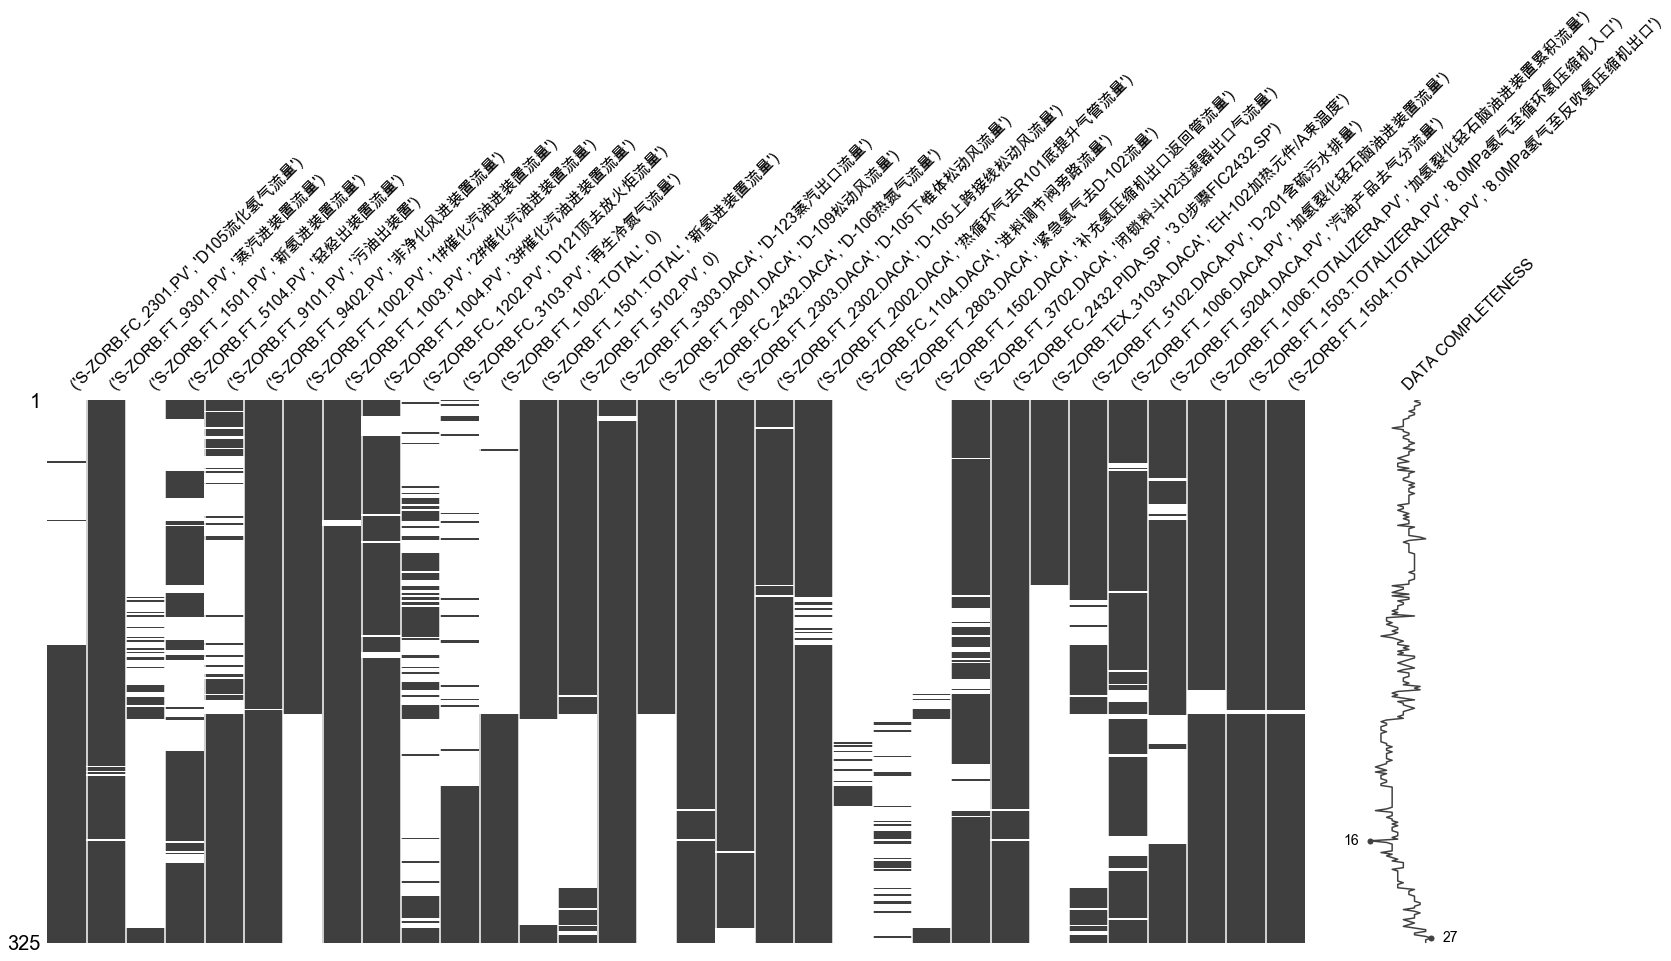

In [24]:
# 可视化呈现 样本数据 中属性中属性值存在零值的属性的分布
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_dummy_columns].replace(0, np.nan), labels=True)

结合背景信息和样本数据的时间分布，可以看做制作工艺优化过程中其属性被优化的过程，于是首先将大范围

In [25]:
# 对 缺失值较多属性值 的属性进行丢弃 对 缺失值较少属性值 的属性进行插值
# 缺失值比例
missing_value_ratio = 0.95  # 需要调整的参数
samples_delete_columns = []
samples_insert_columns = []
for (code_name, i18n_name) in samples_nonzeroratio.keys():
    if samples_nonzeroratio[(code_name, i18n_name)] < missing_value_ratio:
        # print(f"code_name: {code_name} => nonzero_ratio: {samples_nonzeroratio[(code_name, i18n_name)]}")
        samples_delete_columns.append((code_name, i18n_name))
    elif missing_value_ratio <= samples_nonzeroratio[(code_name, i18n_name)] < 1:
        samples_insert_columns.append((code_name, i18n_name))
# print(samples_insert_columns)
samples = samples.drop(columns=samples_delete_columns, axis=1)
samples.shape

(325, 349)

<AxesSubplot:>

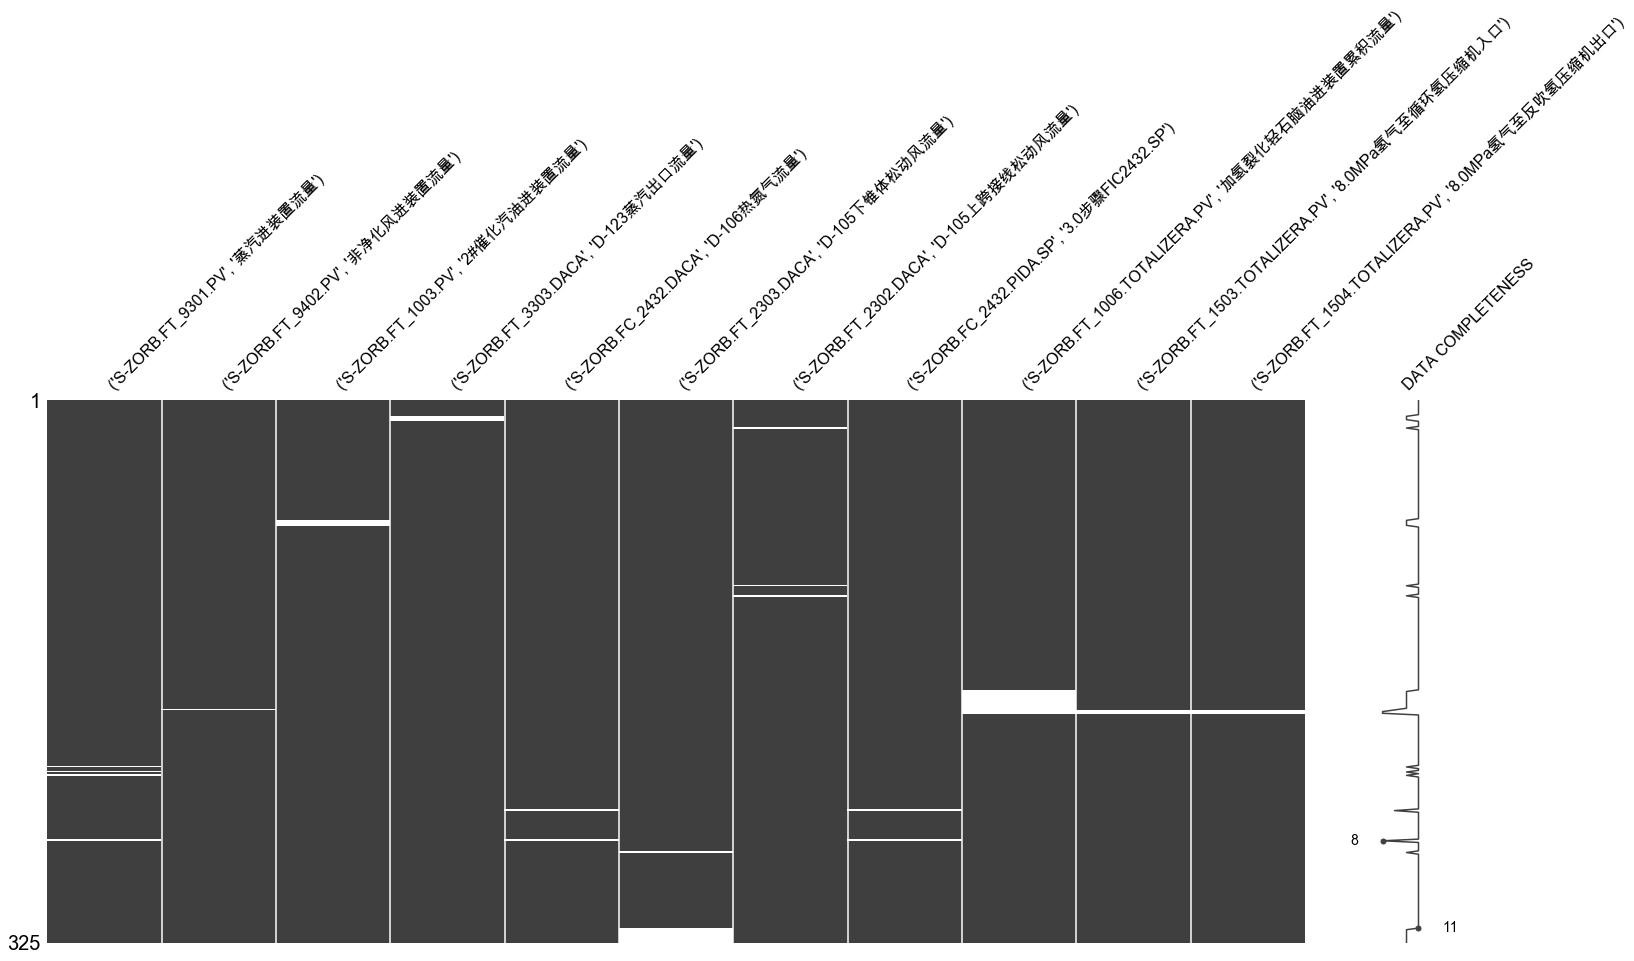

In [26]:
# 可视化呈现 样本数据 中属性中属性值需要进行填充的情况
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_insert_columns].replace(0, np.nan), labels=True)

In [27]:
# 使用线性方程对缺失的属性值进行插值操作
samples = samples.replace(0, np.nan).interpolate(method='linear')

<AxesSubplot:>

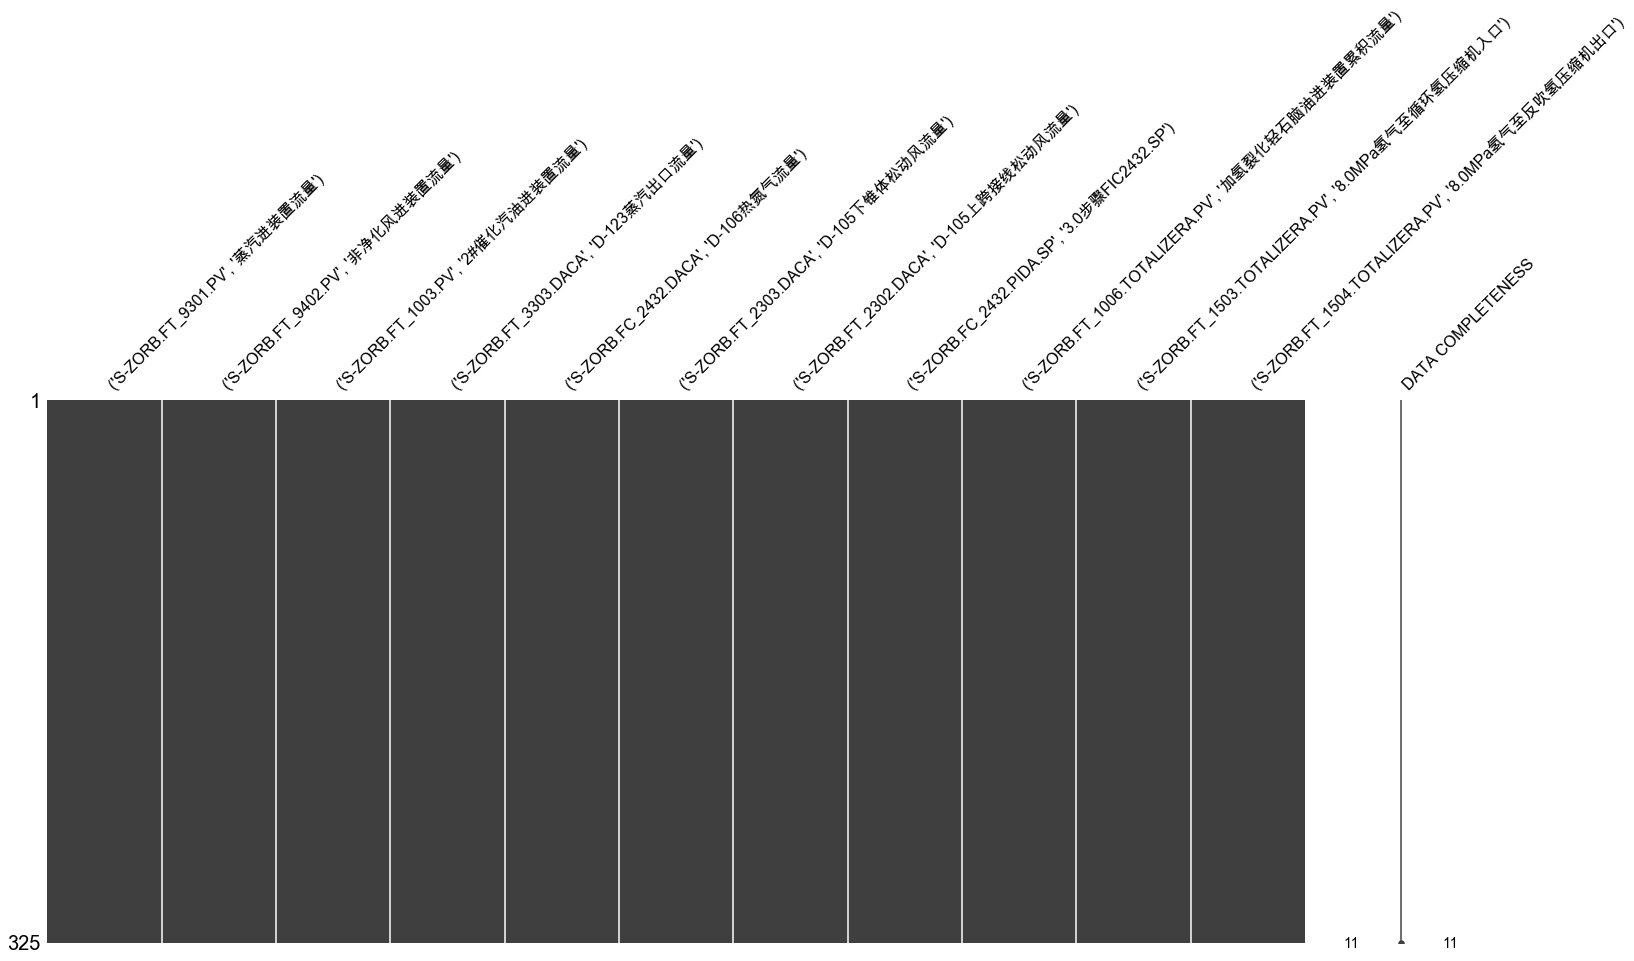

In [28]:
# 可视化呈现 样本数据 中属性中属性值插值的情况
import missingno as msno
%matplotlib inline
msno.matrix(samples[samples_insert_columns].replace(0, np.nan), labels=True)

In [29]:
# 对 367个特征属性 进行提取与分类 
samples_features = samples.iloc[:, 2:]
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

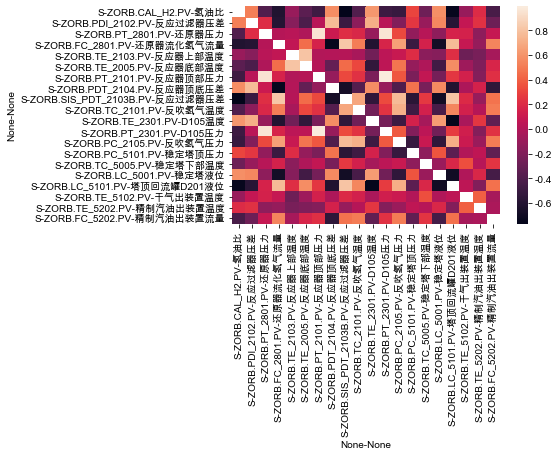

In [30]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').replace(1.0, np.nan)
# 展示 属性间 相关关系 热力图
sns.heatmap(manule_features_corr.iloc[:20, :20])

In [31]:
# 剔除属性间 强相关的属性 阈值 0.8
columns = np.full((manule_features_corr.shape[0],), True, dtype=bool)
for i in range(manule_features_corr.shape[0]):
    for j in range(i + 1, manule_features_corr.shape[0]):
        if abs(manule_features_corr.iloc[i, j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = manule_features.columns[columns]
manule_features = manule_features[selected_columns]

In [32]:
manule_features.shape

(325, 149)

In [33]:
# 通过P-value选取特征属性
import statsmodels.regression.linear_model as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.25
data_modeled, selected_columns = backwardElimination(manule_features.values, produc_features[('产品性质', 'RON损失\n（不是变量）')].values, SL, selected_columns)
manule_features = manule_features[selected_columns]

In [34]:
manule_features.shape

(325, 57)

In [35]:
print(source_features.shape)
print(produc_features.shape)
print(manule_features.shape)

(325, 7)
(325, 3)
(325, 57)


In [36]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold,datasets
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
re_dimension = 30  # 需要调整的参数
tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
X_tsne = tsne.fit_transform(X)
print(f"原始样本数据维度 {X.shape[-1]}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")

原始样本数据维度 57. t-SNE降维后的数据维度 30


In [38]:
# 根据 新特征属性 与 辛烷值RON损失 的相关系数，筛选 相关系数 大于设定阈值的 新特征属性 作为构建函数目标属性
# 新特征属性 与 辛烷值RON损失 与 相关系数的阈值
dist_standard2 = 0.15  # 需要调整的参数
tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
const_features = []
for _ in tSNE_features.keys():
    feature_corr = abs(produc_features[('产品性质', 'RON损失\n（不是变量）')].corr(tSNE_features[_], method="spearman"))
    if feature_corr > dist_standard2:
        print(f"{'='*10} 特征名称: {_} {'='*10}")
        print(f"与 RON损失\n（不是变量） 的相关系数: {feature_corr}")
        const_features.append(_)
print(f"t-SNE feature is => {list(const_features)}")

========== 特征名称: feature_2 ==========
与 RON损失
（不是变量） 的相关系数: 0.2648370232909847
========== 特征名称: feature_4 ==========
与 RON损失
（不是变量） 的相关系数: 0.18040503457710463
========== 特征名称: feature_6 ==========
与 RON损失
（不是变量） 的相关系数: 0.21705009681535842
========== 特征名称: feature_10 ==========
与 RON损失
（不是变量） 的相关系数: 0.20615662540232152
t-SNE feature is => ['feature_2', 'feature_4', 'feature_6', 'feature_10']


In [39]:
# 新特征属性 与 原始属性 与 P-value
SL = 0.05
relate_features = set()
for _ in const_features:
    data_modeled, selected_columns = backwardElimination(manule_features.values, tSNE_features[_].values, SL, manule_features.keys())
    for column in selected_columns:
        relate_features.add(column)
print(f"t-SNE feature relate to => {list(relate_features)} {len(relate_features)}")   

t-SNE feature relate to => [('S-ZORB.FT_1204.PV', 0), ('S-ZORB.PDT_1003.DACA', 'P-101B入口过滤器差压'), ('S-ZORB.FT_9201.PV', '循环水进装置流量'), ('S-ZORB.AT_1001.PV', '进装置原料硫含量'), ('S-ZORB.LC_1202.PV', 'D121液面'), ('S-ZORB.FT_3302.DACA', 'P-105A/B出口总管流量'), ('S-ZORB.PDT_2503.DACA', 'D-107底排放滑阀压差'), ('S-ZORB.AC_6001.PV', '加热炉氧含量'), ('S-ZORB.TC_2201.OP', 'EH101出口'), ('S-ZORB.PDT_1004.DACA', 'ME-104出入口'), ('S-ZORB.PDT_2604.PV', '再生器顶底差压'), ('S-ZORB.FT_9102.PV', 0), ('S-ZORB.FT_1301.DACA', 'K-103出口去K-101出口管流量'), ('S-ZORB.FT_9002.DACA', 'D203出口燃料气流量'), ('S-ZORB.AT_1001.DACA', '原料汽油硫含量'), ('S-ZORB.TE_1102.DACA', 'E-101壳程入口总管温度'), ('S-ZORB.TC_2607.PV', '再生器温度'), ('S-ZORB.PDT_3002.DACA', 'ME-105过滤器压差'), ('S-ZORB.FT_2302.DACA', 'D-105上跨接线松动风流量'), ('S-ZORB.FT_9301.PV', '蒸汽进装置流量'), ('S-ZORB.PDC_2502.PV', 'D107转剂线压差'), ('S-ZORB.AI_2903.PV', '再生烟气氧含量'), ('S-ZORB.FT_1204.DACA.PV', 'D-121含硫污水排量'), ('S-ZORB.FC_1005.PV', '原料泵出口流量'), ('S-ZORB.FC_5103.DACA', '稳定塔顶回流流量'), ('S-ZORB.TE_7106.DACA', 'K-101A左排气温度'), ('S-ZORB

In [40]:
manule_feature = manule_features[list(relate_features)]
manule_feature_corr = manule_feature.corr(method='spearman')
# 剔除属性间 强相关的属性 阈值 0.4
relate_corr_standard = 0.4
columns = np.full((manule_feature_corr.shape[0],), True, dtype=bool)
for i in range(manule_feature_corr.shape[0]):
    for j in range(i + 1, manule_feature_corr.shape[0]):
        if abs(manule_feature_corr.iloc[i, j]) >= relate_corr_standard:
            if columns[j]:
                columns[j] = False
selected_columns = manule_feature.columns[columns]
manule_features = manule_features[selected_columns]
relate_features = set(manule_features.keys())

In [41]:
manule_features

,S-ZORB.FT_1204.PV,S-ZORB.PDT_1003.DACA,S-ZORB.FT_9201.PV,S-ZORB.AT_1001.PV,S-ZORB.LC_1202.PV,S-ZORB.PDT_1004.DACA,S-ZORB.PDT_2604.PV,S-ZORB.FT_1301.DACA,S-ZORB.FT_9002.DACA,S-ZORB.TC_2607.PV,S-ZORB.FC_1005.PV,S-ZORB.TE_1203.PV
,0,P-101B入口过滤器差压,循环水进装置流量,进装置原料硫含量,D121液面,ME-104出入口,再生器顶底差压,K-103出口去K-101出口管流量,D203出口燃料气流量,再生器温度,原料泵出口流量,D121温度
0,44.755820,0.615028,397.265200,187.144500,49.951488,7.718856,36.278202,1098.744090,452.796620,491.801150,133.911720,31.713212
1,44.755820,0.617141,398.995980,187.144500,49.969321,8.108117,35.840754,791.314515,470.734730,481.189695,134.031585,30.454282
2,44.755820,0.622869,402.394630,187.144500,50.013484,7.436623,34.596037,1128.474650,459.350950,510.227770,133.862665,27.543542
3,44.755820,0.629283,398.369810,187.144500,49.995577,6.719556,36.142731,670.460165,438.996390,497.568265,133.911160,30.270829
4,44.755820,7.598486,398.890970,187.144500,49.979899,7.347256,35.346175,1079.454895,401.751800,501.097185,133.187540,30.113963
...,...,...,...,...,...,...,...,...,...,...,...,...
320,53.433535,9.632140,478.766410,225.020775,50.023680,7.533620,40.139151,2933.872700,446.516808,489.138528,139.772818,33.875841
321,76.606090,9.607235,481.129270,224.013005,49.998568,6.784938,38.311250,2911.157550,447.316282,485.254352,140.046538,33.267227
322,53.357489,9.574362,480.984932,213.336115,49.981726,6.244805,39.095575,3324.242600,424.551558,497.497753,139.676740,33.841512


### 问题三：

建立辛烷值（RON）损失预测模型：采用上述样本和建模主要变量，通过数据挖掘技术建立辛烷值（RON）损失预测模型，并进行模型验证。

In [42]:
# 尝试使用 多元线性回归 建模
# 构造训练集和测试集
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression  # 线性回归
from sklearn.model_selection import train_test_split  # 这里是引用了交叉验证
from sklearn.metrics.regression import mean_squared_error, r2_score

In [43]:
pre_model_feature = manule_features[list(relate_features)]
model_features = pre_model_feature.join(samples[[('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g'), ('待生吸附剂性质', '焦炭,wt%'), ('待生吸附剂性质', 'S, wt%'), ('再生吸附剂性质', '焦炭,wt%'), ('再生吸附剂性质', 'S, wt%'), ('产品性质', '硫含量,μg/g'), ('产品性质', '辛烷值RON'), ('产品性质', 'RON损失\n（不是变量）')]])
model_features.describe()

S-ZORB.FT_1204.PV S-ZORB.PDT_1004.DACA S-ZORB.PDT_2604.PV  \
                      0            ME-104出入口            再生器顶底差压   
count        325.000000           325.000000         325.000000   
mean          44.564264            22.495966          37.785931   
std           12.120894            12.924540           2.314919   
min            0.889900            -0.903632          22.599062   
25%           43.130860            11.666279          36.532314   
50%           44.755820            23.440942          37.913615   
75%           44.755820            32.311808          39.138461   
max          196.901288            54.770501          43.118692   

      S-ZORB.FT_1301.DACA S-ZORB.PDT_1003.DACA S-ZORB.FT_9002.DACA  \
       K-103出口去K-101出口管流量        P-101B入口过滤器差压         D203出口燃料气流量   
count          325.000000           325.000000          325.000000   
mean          1142.077954             5.803041          453.283874   
std            503.391613             4.125561           51.729508   
min            132.742235            -1.256850          330.560980   
25%            848.787264             0.623778          419.191480   
50%           1027.947850             8.561416          446.454290   
75%           1294.327215             9.170029          473.829067   
max           3324.242600            11.556480          635.402730   

      S-ZORB.FC_1005.PV S-ZORB.FT_9201.PV S-ZORB.AT_1001.PV S-ZORB.LC_1202.PV  \
                原料泵出口流量          循环水进装置流量          进装置原料硫含量            D121液面   
count        325.000000        325.000000        325.000000        325.000000   
mean         137.872080        446.466958        217.919577         50.021441   
std            4.834626         61.030230         55.825776          0.120841   
min           99.598683        256.469665          1.582905         49.699286   
25%          135.504213        424.018085        187.144500         49.986457   
50%          139.611697        438.141960        187.144500         50.001487   
75%          140.410988        465.185320        253.656907         50.016935   
max          149.772425        824.263118        640.510195         50.858507   

       ... S-ZORB.TE_1203.PV        原料性质                 待生吸附剂性质              \
       ...            D121温度      辛烷值RON    硫含量,μg/g      焦炭,wt%      S, wt%   
count  ...        325.000000  325.000000  325.000000  325.000000  325.000000   
mean   ...         33.949177   89.701077  229.714179    3.184933    8.073465   
std    ...          2.552216    0.950296   65.742710    2.000743    2.124257   
min    ...         27.254023   85.300000   57.000000    1.010000    2.940000   
25%    ...         32.245186   89.200000  185.000000    1.850000    7.080000   
50%    ...         33.968476   89.800000  240.285714    2.390000    8.400000   
75%    ...         35.833336   90.300000  271.428571    3.880000    9.370000   
max    ...         40.469099   91.700000  392.000000   12.150000   14.310000   

          再生吸附剂性质                    产品性质                            
           焦炭,wt%      S, wt%    硫含量,μg/g      辛烷值RON RON损失\n（不是变量）  
count  325.000000  325.000000  325.000000  325.000000    325.000000  
mean     1.649783    5.966947    4.067692   88.446031      1.255046  
std      1.340660    1.852137    1.555408    0.985030      0.225779  
min      0.250000    1.430000    3.200000   85.100000      0.200000  
25%      0.933333    4.910000    3.200000   87.900000      1.120000  
50%      1.280000    6.080000    3.200000   88.600000      1.240000  
75%      1.750000    6.950000    4.400000   89.100000      1.380000  
max      8.920000   13.340000   11.800000   90.420000      1.820000  

[8 rows x 21 columns]

In [44]:
# 增加题目要求的变量作为建模属性
relate_features.add(('原料性质', '辛烷值RON'))
relate_features.add(('待生吸附剂性质', '焦炭,wt%'))
relate_features.add(('待生吸附剂性质', 'S, wt%'))
relate_features.add(('再生吸附剂性质', '焦炭,wt%'))
relate_features.add(('再生吸附剂性质', 'S, wt%'))
X = model_features[list(relate_features)]
y = model_features[[('产品性质', 'RON损失\n（不是变量）')]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('X_train.shape={}\ny_train.shape={}\nX_test.shape={}\ny_test.shape={}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape=(260, 17)
y_train.shape=(260, 1)
X_test.shape=(65, 17)
y_test.shape=(65, 1)


In [45]:
# 简单线性回归
# Applying LinearRegression
RON_linreg = LinearRegression()
RON_linreg.fit(X_train, y_train)
y_train_pred = RON_linreg.predict(X_train)
y_test_pred = RON_linreg.predict(X_test)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.043, test:0.040
R^2 train:0.178, test:0.107


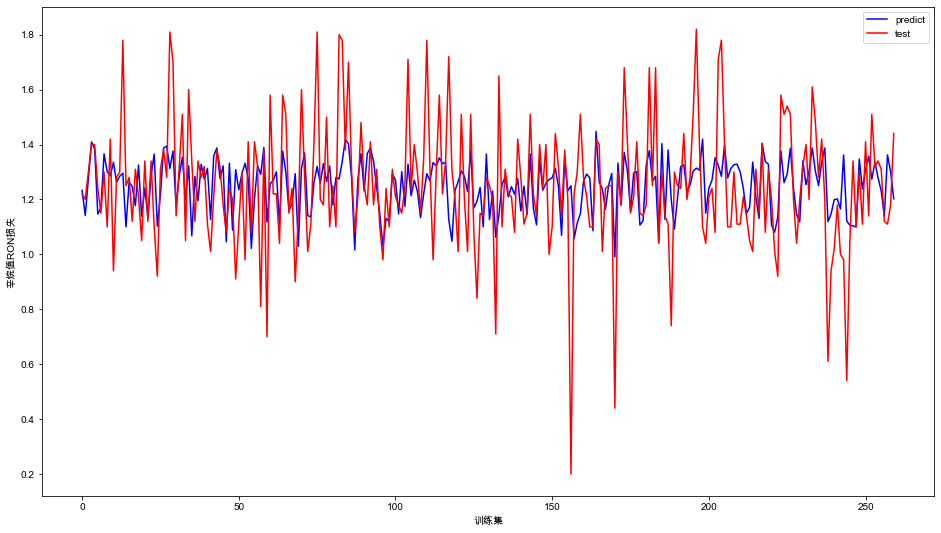

In [46]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") # 显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

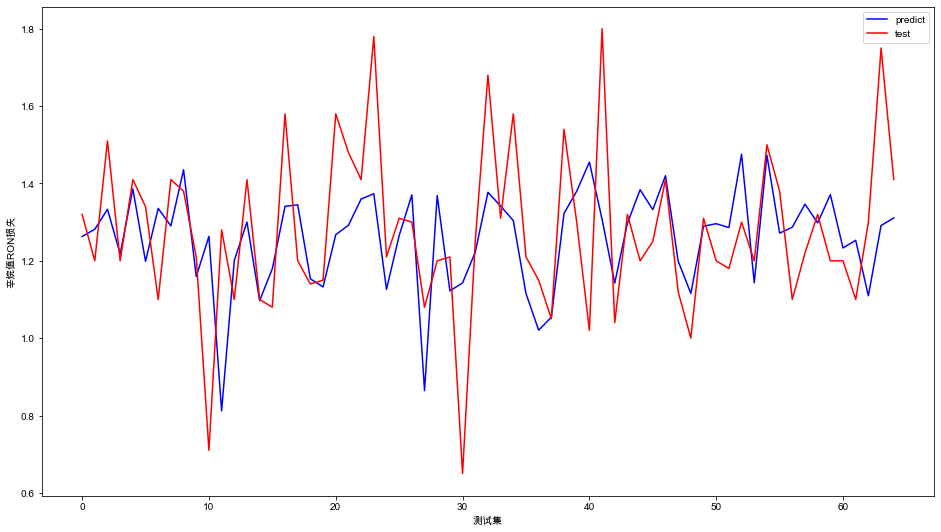

In [47]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") # 显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()

In [48]:
# 多项式回归
# Applying PolynomialFeatures
quadratic_featurizer = PolynomialFeatures(degree=2)
X_test_quadratic = quadratic_featurizer.fit_transform(X_test)
X_train_quadratic = quadratic_featurizer.fit_transform(X_train)
RON_poly_linreg = LinearRegression()
RON_poly_linreg.fit(X_train_quadratic, y_train)
y_test_pred = RON_poly_linreg.predict(X_test_quadratic)
y_train_pred = RON_poly_linreg.predict(X_train_quadratic)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.078, test:3.053
R^2 train:-0.497, test:-67.302


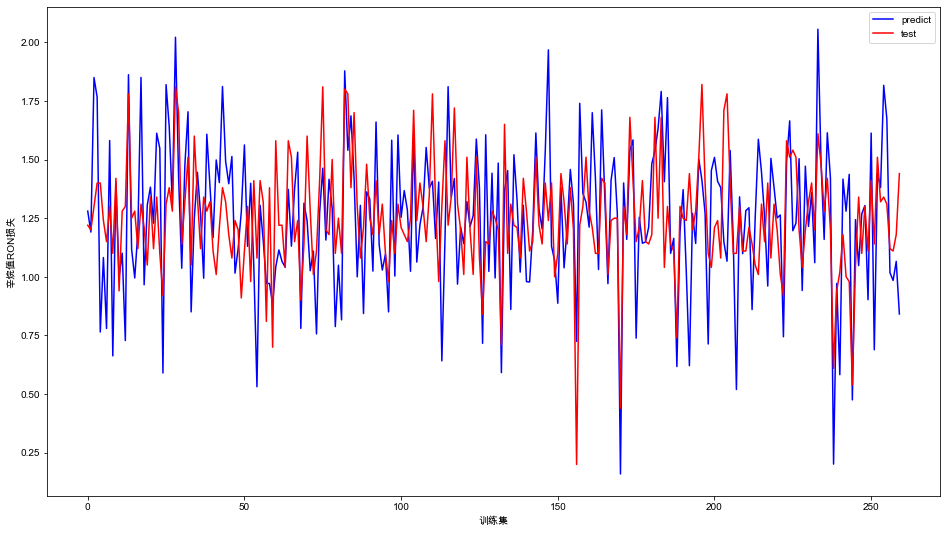

In [49]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

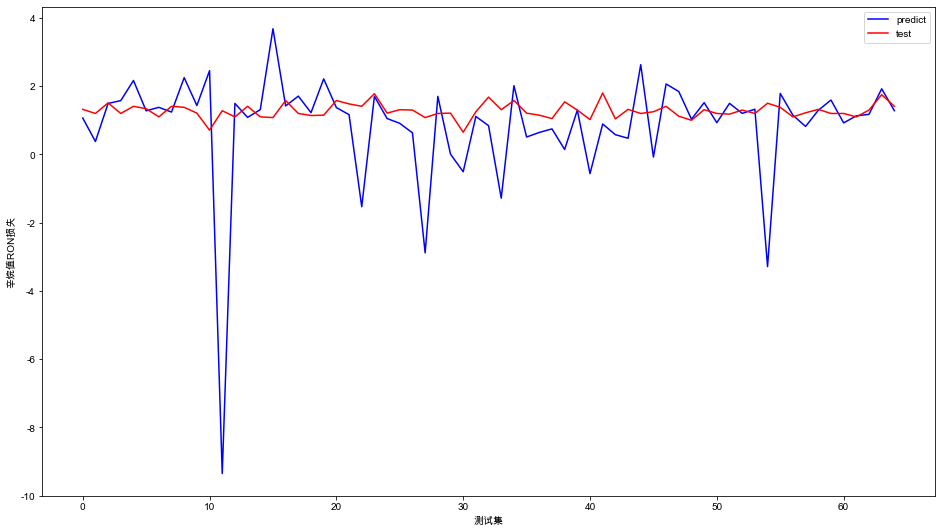

In [50]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()

In [51]:
tSNE_model_features = tSNE_features.join(samples[[('原料性质', '辛烷值RON'), ('原料性质', '硫含量,μg/g'), ('产品性质', '辛烷值RON'), ('产品性质', 'RON损失\n（不是变量）')]])
tSNE_model_features.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,"(原料性质, 辛烷值RON)","(原料性质, 硫含量,μg/g)","(产品性质, 辛烷值RON)","(产品性质, RON损失\n（不是变量）)"
count,3.250000e+02,3.250000e+02,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,3.250000e+02,3.250000e+02,...,3.250000e+02,3.250000e+02,3.250000e+02,3.250000e+02,325.000000,3.250000e+02,325.000000,325.000000,325.000000,325.000000
mean,0.000000e+00,3.076923e-03,-0.000192,0.000048,0.000012,-0.000002,0.000012,0.000012,-3.756010e-07,-3.756010e-07,...,5.868765e-09,-1.173753e-08,2.347506e-08,-2.347506e-08,0.000000,5.868765e-09,89.701077,229.714179,88.446031,1.255046
std,4.347510e+06,4.737109e+05,43509.343750,3633.585205,504.830688,502.772064,424.649475,356.616730,7.489091e+01,7.100204e+01,...,5.831997e+00,5.033195e+00,4.970103e+00,4.506645e+00,3.817946,3.134076e+00,0.950296,65.742710,0.985030,0.225779
min,-1.744081e+06,-1.123035e+06,-8358.326172,-8629.861328,-1203.434326,-688.944336,-944.480469,-779.751404,-2.666310e+02,-2.083820e+02,...,-2.257503e+01,-1.510829e+01,-1.647813e+01,-1.547171e+01,-11.305808,-8.220143e+00,85.300000,57.000000,85.100000,0.200000
25%,-1.743894e+06,4.357764e+04,-8339.459961,-2720.752197,-334.662689,-90.599846,-380.846771,-271.790894,-4.701608e+01,-2.709208e+01,...,-3.132457e+00,-3.402609e+00,-2.794771e+00,-2.733161e+00,-1.878924,-1.539741e+00,89.200000,185.000000,87.900000,1.120000
50%,-1.743745e+06,4.399889e+04,-8318.483398,-300.474091,-26.878347,-21.730286,61.247341,-6.722179,5.371602e+00,-3.515028e-01,...,-2.447447e-01,-3.667418e-01,-2.728718e-01,4.008030e-01,0.126594,-2.438256e-01,89.800000,240.285714,88.600000,1.240000
75%,-1.743607e+06,4.442985e+04,-8278.740234,2349.545654,310.862823,56.555054,297.810669,194.540192,4.585153e+01,2.153531e+01,...,2.907802e+00,3.014782e+00,2.541019e+00,2.708476e+00,1.874310,1.347259e+00,90.300000,271.428571,89.100000,1.380000
max,1.718075e+07,4.042130e+06,365582.218750,11319.514648,1530.809204,6424.178223,1123.962769,1673.002075,4.088539e+02,3.498832e+02,...,3.542721e+01,1.744561e+01,2.948155e+01,2.045439e+01,14.686508,3.039668e+01,91.700000,392.000000,90.420000,1.820000


In [52]:
X = tSNE_model_features[list(tSNE_features.keys())]
y = tSNE_model_features[[('产品性质', 'RON损失\n（不是变量）')]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
print('X_train.shape={}\ny_train.shape={}\nX_test.shape={}\ny_test.shape={}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape=(243, 30)
y_train.shape=(243, 1)
X_test.shape=(82, 30)
y_test.shape=(82, 1)


In [53]:
# 简单线性回归
# Applying LinearRegression
tSNE_RON_linreg = LinearRegression()
tSNE_RON_linreg.fit(X_train, y_train)
y_train_pred = tSNE_RON_linreg.predict(X_train)
y_test_pred = tSNE_RON_linreg.predict(X_test)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.039, test:0.041
R^2 train:0.264, test:0.052


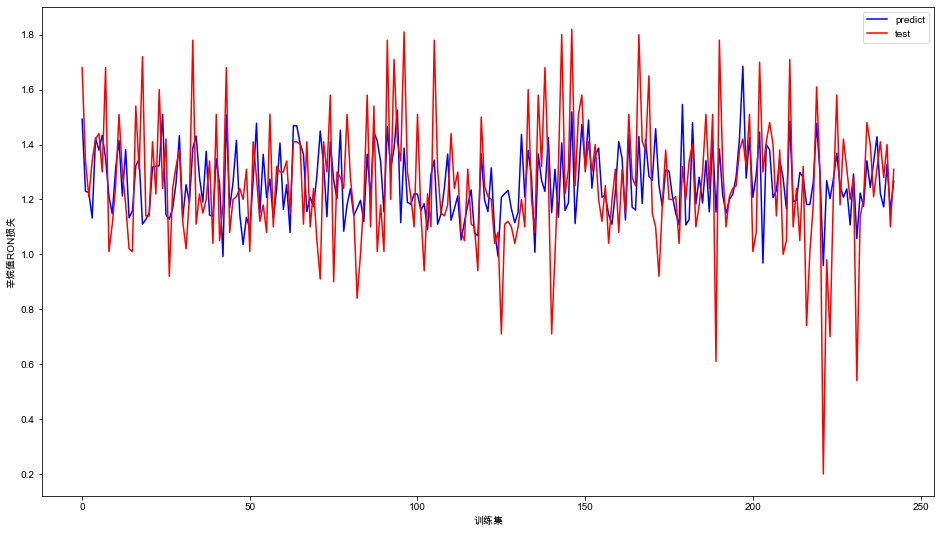

In [54]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

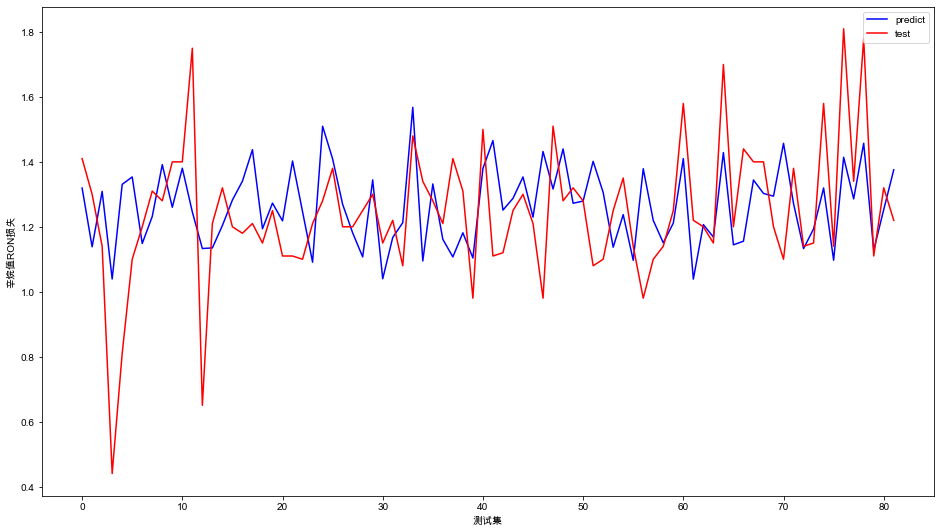

In [55]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()

In [56]:
# 多项式回归
# Applying PolynomialFeatures
quadratic_featurizer = PolynomialFeatures(degree=2)
X_test_quadratic = quadratic_featurizer.fit_transform(X_test)
X_train_quadratic = quadratic_featurizer.fit_transform(X_train)

tSNE_RON_poly_linreg = LinearRegression()
tSNE_RON_poly_linreg.fit(X_train_quadratic, y_train)
y_test_pred = tSNE_RON_poly_linreg.predict(X_test_quadratic)
y_train_pred = tSNE_RON_poly_linreg.predict(X_train_quadratic)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.042, test:0.075
R^2 train:0.219, test:-0.733


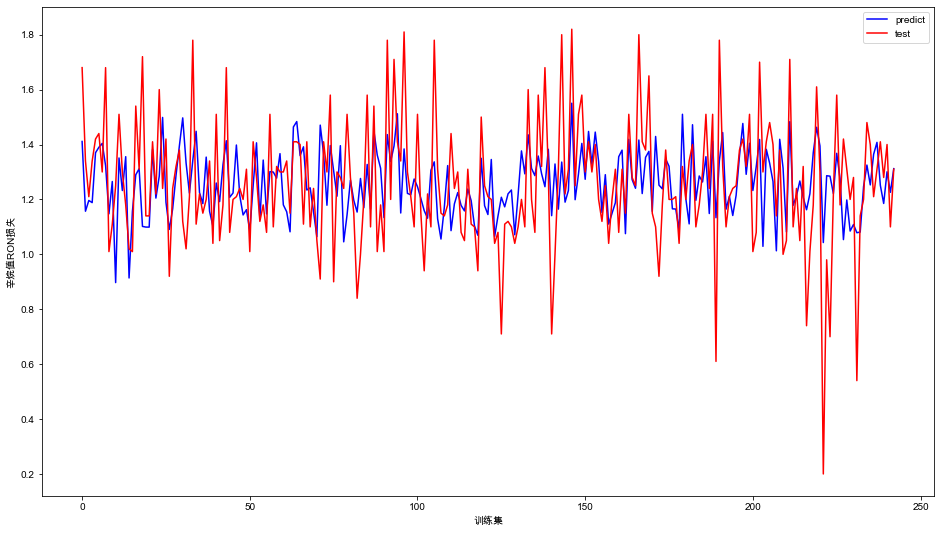

In [57]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("辛烷值RON损失")
plt.show()

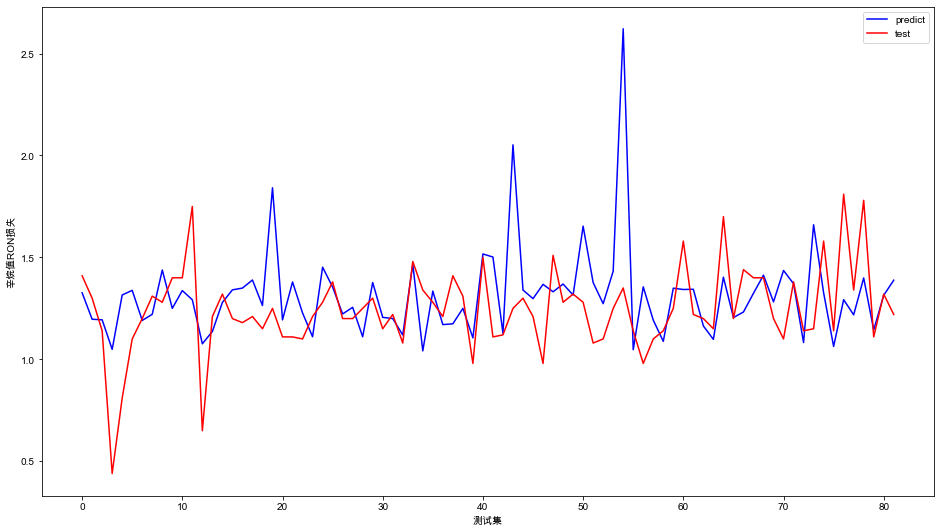

In [58]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("辛烷值RON损失")
plt.show()

### 问题四：

主要变量操作方案的优化：要求在保证产品硫含量不大于5μg/g的前提下，利用你们的模型获得325个数据样本(见附件四“325个数据样本数据.xlsx”)中，辛烷值（RON）损失降幅大于30%的样本对应的主要变量优化后的操作条件（优化过程中原料、待生吸附剂、再生吸附剂的性质保持不变，以它们在样本中的数据为准）。

In [59]:
# 增加题目要求的变量作为建模属性
relate_features.add(('待生吸附剂性质', '焦炭,wt%'))
relate_features.add(('待生吸附剂性质', 'S, wt%'))
relate_features.add(('再生吸附剂性质', '焦炭,wt%'))
relate_features.add(('再生吸附剂性质', 'S, wt%'))
X = model_features[list(relate_features)]
y = model_features[[('产品性质', '硫含量,μg/g')]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
print('X_train.shape={}\ny_train.shape={}\nX_test.shape={}\ny_test.shape={}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train.shape=(243, 17)
y_train.shape=(243, 1)
X_test.shape=(82, 17)
y_test.shape=(82, 1)


In [60]:
# 简单线性回归
# Applying LinearRegression
S_linreg = LinearRegression()
S_linreg.fit(X_train, y_train)
y_train_pred = S_linreg.predict(X_train)
y_test_pred = S_linreg.predict(X_test)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:1.718, test:2.440
R^2 train:0.253, test:0.111


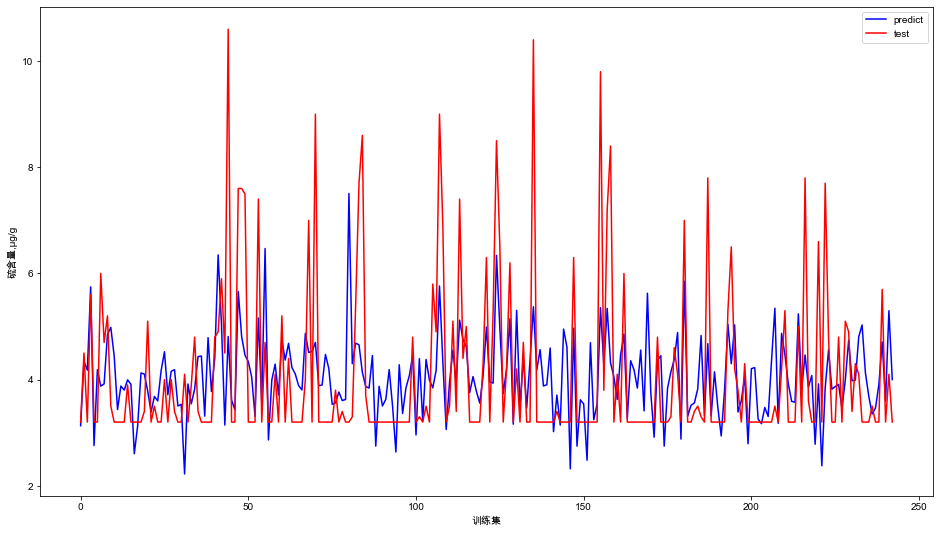

In [61]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") # 显示图中的标签
plt.xlabel("训练集")
plt.ylabel("硫含量,μg/g")
plt.show()

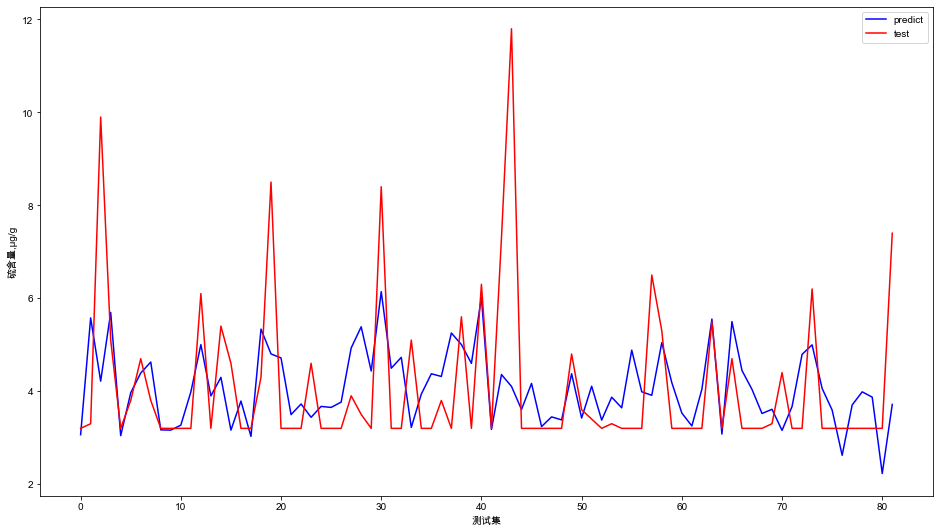

In [62]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") # 显示图中的标签
plt.xlabel("测试集")
plt.ylabel("硫含量,μg/g")
plt.show()

In [63]:
# 多项式回归
# Applying PolynomialFeatures
quadratic_featurizer = PolynomialFeatures(degree=2)
X_test_quadratic = quadratic_featurizer.fit_transform(X_test)
X_train_quadratic = quadratic_featurizer.fit_transform(X_train)

S_poly_linreg = LinearRegression()
S_poly_linreg.fit(X_train_quadratic, y_train)
y_test_pred = S_poly_linreg.predict(X_test_quadratic)
y_train_pred = S_poly_linreg.predict(X_train_quadratic)
print ('MSE train:%.3f, test:%.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print ('R^2 train:%.3f, test:%.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train:0.302, test:26.031
R^2 train:0.869, test:-8.483


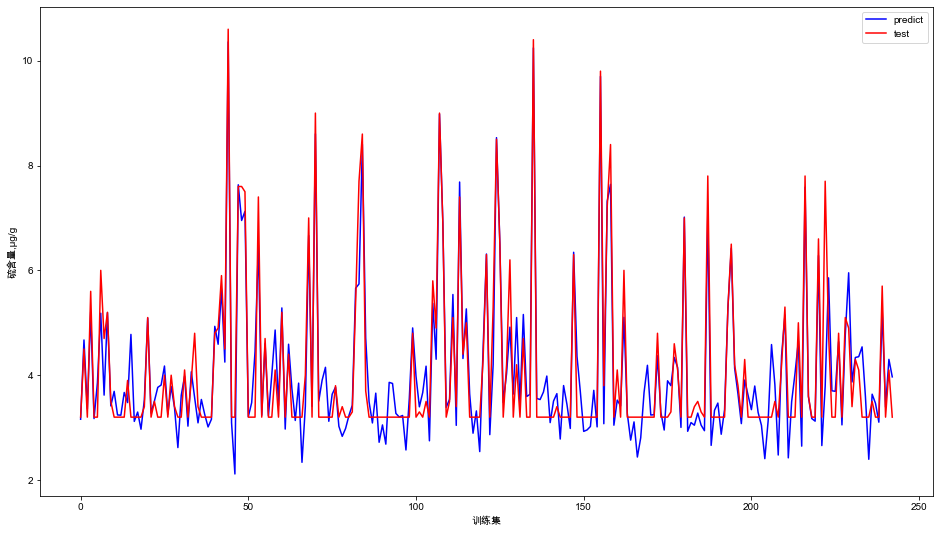

In [64]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_train)), y_train_pred, 'b', label="predict")
plt.plot(range(len(y_train)), y_train, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("训练集")
plt.ylabel("硫含量,μg/g")
plt.show()

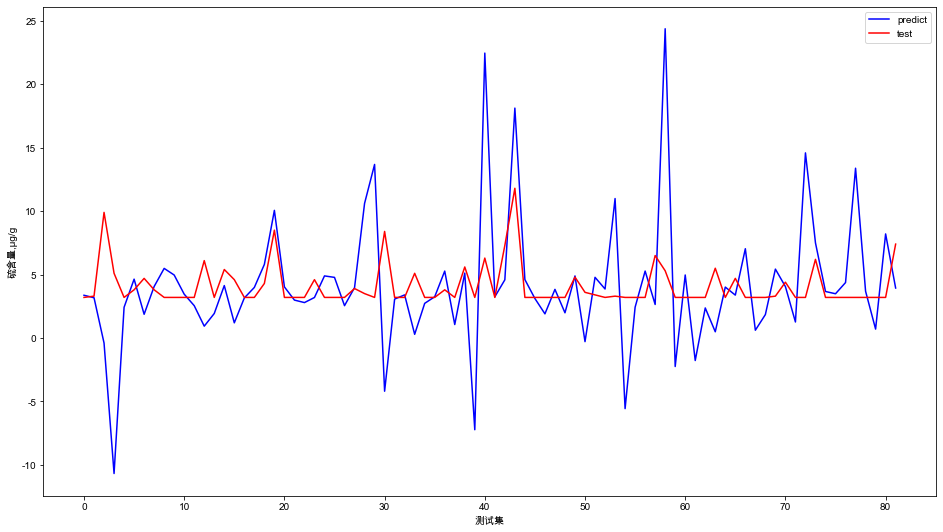

In [65]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_test)), y_test_pred, 'b', label="predict")
plt.plot(range(len(y_test)), y_test, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("硫含量,μg/g")
plt.show()

于是根据上面的模型建立结果，两个模型方程均选择 多项式回归模型，在题目的条件下，分别对 两个模型方程 (辛烷值损失方程和硫含量方程) 进行预测

+ 利用 辛烷值损失模型 通过 325个样本 产生 325个辛烷值损失数据，假定此次为正确值，通过对操作变量的调节再进行测试，对比前后值来判断如何操作能够降低 辛烷值损失达到百分之三十
    - 操作不能影响产品中 硫含量，即假定 同样模型参数下 硫含量模型产生的 325个硫含量样本数据 为准，对操作变量的调节不能影响其输出
    - 对变量的操作依据 附件四 进行

In [66]:
# 使用全部样本作为样本输出
X_quadratic = quadratic_featurizer.fit_transform(X)
# 辛烷值含量损失 模型
y_RON_pred = RON_poly_linreg.predict(X_quadratic)
# 产品硫含量 模型
y_S_pred = S_poly_linreg.predict(X_quadratic)

RON_adjust_df = pd.DataFrame(y_RON_pred, columns=['RON_Sample'])
S_adjust_df = pd.DataFrame(y_RON_pred, columns=['S_Sample'])

for _ in list(pre_model_feature):
    print(f"{_} 均值: {model_features[_].mean()}")

('S-ZORB.FT_1204.PV', 0) 均值: 44.56426410186923
('S-ZORB.PDT_1004.DACA', 'ME-104出入口') 均值: 22.495966002073864
('S-ZORB.PDT_2604.PV', '再生器顶底差压') 均值: 37.78593097514511
('S-ZORB.FT_1301.DACA', 'K-103出口去K-101出口管流量') 均值: 1142.0779541168356
('S-ZORB.PDT_1003.DACA', 'P-101B入口过滤器差压') 均值: 5.803041181560931
('S-ZORB.FT_9002.DACA', 'D203出口燃料气流量') 均值: 453.28387401679345
('S-ZORB.FC_1005.PV', '原料泵出口流量') 均值: 137.87207981828965
('S-ZORB.FT_9201.PV', '循环水进装置流量') 均值: 446.46695831273604
('S-ZORB.AT_1001.PV', '进装置原料硫含量') 均值: 217.9195770273077
('S-ZORB.LC_1202.PV', 'D121液面') 均值: 50.021440941715966
('S-ZORB.TC_2607.PV', '再生器温度') 均值: 498.9206794325443
('S-ZORB.TE_1203.PV', 'D121温度') 均值: 33.9491768264807


In [67]:
# 更改 操作属性 例如 对 ('S-ZORB.TC_2607.PV', '再生器温度') 参数进行调整
NEW_X = X
NEW_X[('S-ZORB.TC_2607.PV', '再生器温度')] = NEW_X[('S-ZORB.TC_2607.PV', '再生器温度')].map(lambda x: x - 1)
modify_X_quadratic = quadratic_featurizer.fit_transform(NEW_X)
modify_y_RON_pred = RON_poly_linreg.predict(modify_X_quadratic)
modify_y_S_pred = S_poly_linreg.predict(modify_X_quadratic)

# 将调整的参数存入各自对应的df中
RON_adjust_df["RON_modify"] = modify_y_RON_pred
S_adjust_df["S_modify"] = modify_y_S_pred

In [68]:
RON_adjust_df["reduce"] = (RON_adjust_df["RON_modify"] - RON_adjust_df["RON_Sample"]) / RON_adjust_df["RON_Sample"] * 100
print('辛烷值RON损失 降低: {} %'.format(RON_adjust_df["reduce"].mean()))

辛烷值RON损失 降低: -0.940522669339576 %


In [69]:
print('产品硫含量 中位数: {} μg/g'.format(S_adjust_df["S_modify"].median()))

产品硫含量 中位数: 3.6309440825134516 μg/g


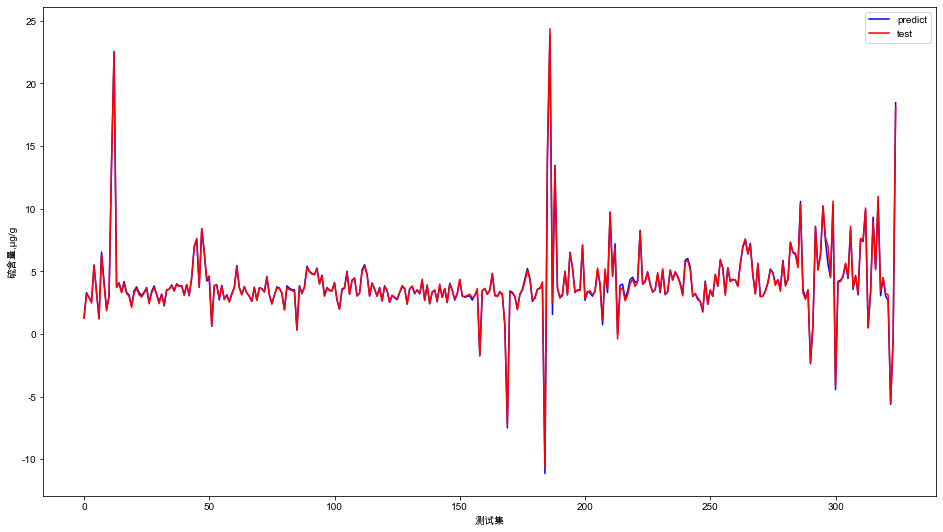

In [70]:
plt.figure(figsize = (16, 9))
plt.plot(range(len(y_S_pred)), modify_y_S_pred, 'b', label="predict")
plt.plot(range(len(y_S_pred)), y_S_pred, 'r', label="test")
plt.legend(loc = "upper right") #显示图中的标签
plt.xlabel("测试集")
plt.ylabel("硫含量,μg/g")
plt.show()

### 问题五：

模型的可视化展示：工业装置为了平稳生产，优化后的主要操作变量（即：问题2中的主要变量）往往只能逐步调整到位，请你们对133号样本（原料性质、待生吸附剂和再生吸附剂的性质数据保持不变，以样本中的数据为准），以图形展示其主要操作变量优化调整过程中对应的汽油辛烷值和硫含量的变化轨迹。（各主要操作变量每次允许调整幅度值Δ见附件四“354个操作变量信息.xlsx”）。

In [71]:
# 更改 操作属性 例如 对 ('S-ZORB.TC_2607.PV', '再生器温度') 参数进行调整
sample_133 = samples.iloc[132]
sample_133 = sample_133[X.keys()]
RON_pred = []
S_pred = []
for temp in np.arange(450, 520, 1):
    sample_133[('S-ZORB.TC_2607.PV', '再生器温度')] = temp
    modify_133_quadratic = quadratic_featurizer.fit_transform([sample_133])
    modify_133_RON_pred = RON_poly_linreg.predict(modify_133_quadratic)
    modify_133_S_pred = S_poly_linreg.predict(modify_133_quadratic)
    RON_pred.append(modify_133_RON_pred[0])
    S_pred.append(modify_133_S_pred[0])

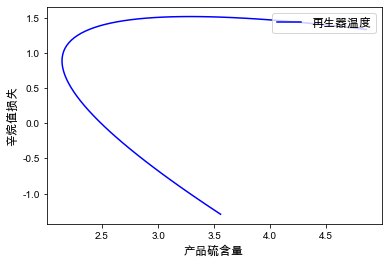

In [72]:
plt.figure()
plt.plot(S_pred, RON_pred, 'b', label="再生器温度")
plt.legend(loc="upper right", fontsize=12) #显示图中的标签
plt.xlabel("产品硫含量", fontsize=12)
plt.ylabel("辛烷值损失", fontsize=12)
plt.show()

In [73]:
# 更改 操作属性 例如 对 ('S-ZORB.TE_1203.PV', 'D121温度') 参数进行调整
RON_pred = []
S_pred = []
for temp in np.arange(25, 50, 1):
    sample_133[('S-ZORB.TE_1203.PV', 'D121温度')] = temp
    modify_133_quadratic = quadratic_featurizer.fit_transform([sample_133])
    modify_133_RON_pred = RON_poly_linreg.predict(modify_133_quadratic)
    modify_133_S_pred = S_poly_linreg.predict(modify_133_quadratic)
    RON_pred.append(modify_133_RON_pred[0])
    S_pred.append(modify_133_S_pred[0])

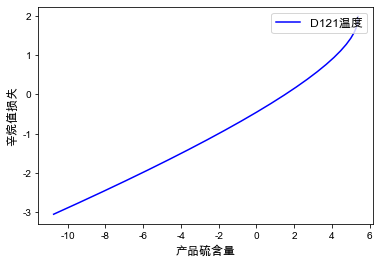

In [74]:
plt.figure()
plt.plot(S_pred, RON_pred, 'b', label="D121温度")
plt.legend(loc="upper right", fontsize=12) #显示图中的标签
plt.xlabel("产品硫含量", fontsize=12)
plt.ylabel("辛烷值损失", fontsize=12)
plt.show()

In [75]:
# 更改 操作属性 例如 对 ('S-ZORB.TC_2607.PV', '再生器温度') 和 ('S-ZORB.TE_1203.PV', 'D121温度') 参数同时进行调整  
RON_pred = []
S_pred = []
sample_133[('S-ZORB.TC_2607.PV', '再生器温度')] = 450
for temp in np.arange(25, 50, 1):
    sample_133[('S-ZORB.TE_1203.PV', 'D121温度')] = temp
    sample_133[('S-ZORB.TC_2607.PV', '再生器温度')] = sample_133[('S-ZORB.TC_2607.PV', '再生器温度')] + 1
    modify_133_quadratic = quadratic_featurizer.fit_transform([sample_133])
    modify_133_RON_pred = RON_poly_linreg.predict(modify_133_quadratic)
    modify_133_S_pred = S_poly_linreg.predict(modify_133_quadratic)
    RON_pred.append(modify_133_RON_pred[0])
    S_pred.append(modify_133_S_pred[0])

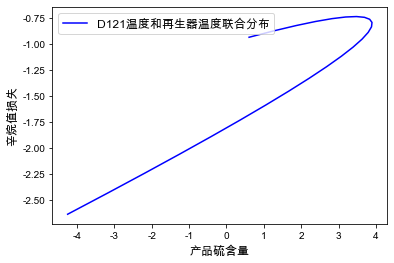

In [77]:
plt.figure()
plt.plot(S_pred, RON_pred, 'b', label="D121温度和再生器温度联合分布")
plt.legend(loc="upper left", fontsize=12) # 显示图中的标签
plt.xlabel("产品硫含量", fontsize=12)
plt.ylabel("辛烷值损失", fontsize=12)
plt.show()